# 2 Continuous FS and SNR estimation with MTL

In this notebook we train a double-headed FCN model that does frame sync and SNR estimation. The whole architecture is fully convolutional and can be applied to arbitrary length inputs. To make life easier for myself, I did all the result plotting in the next notebook -- 3_plotting_results.ipynb.

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from comms import *

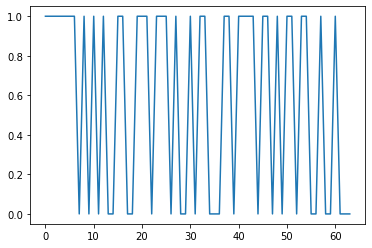

In [2]:
plt.plot(signal.max_len_seq(7)[0][:64])
max_seq = signal.max_len_seq(7)[0][:64]

In [3]:
# make one frame of data with preamble attached with random time offset
def create_frame(preamble_seq, payload=128, signal_length=200, offset=40):
    waveform = np.random.randint(0,2,signal_length)
    waveform[offset:offset+len(preamble_seq)] = preamble_seq
    waveform = np.where(waveform < 1, -1+0j, 1+0j)
    
    return waveform

# Function returns the DER of a binary sequence preamble_seq by using the standard
# correlation under selected impairments.
def calculate_baseline(preamble_seq, snr_range=None, num_iter=1500, payload=128,
                       signal_length=200, add_phase_offset=True, carrier_offset=None,
                       sample_rate=1e6, add_channel=False):
    
    if snr_range is None:
        snr_range = np.arange(-15,10)
    
    preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)

    corr_ers = np.zeros(len(snr_range),)
    
    if carrier_offset:
        offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))

    for idx, snr in enumerate(snr_range):
        corr_err = float(0)
        for i in range(num_iter):

            # Create new frame with a random tau
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))
            my_frame = create_frame(preamble_seq, payload=payload, signal_length=signal_length, offset=tau)
            
            if add_phase_offset:
                ph = np.random.randint(-180,high=181)
                my_frame = phase_offset(my_frame, offset=ph)
                
            if carrier_offset is not None:
                my_frame = my_frame*offset_sine
                
            if add_channel:
                gains = 1/np.sqrt(2)*(np.random.normal(0)+1j*np.random.normal(0))
                my_frame = gains*my_frame
                
            # Add noise
            my_frame = awgn(my_frame, snr)
            
            # Find peaks using correlation
            correlation = np.abs(np.correlate(my_frame, preamble, mode='valid'))
            y_corr = np.argmax(correlation)

            # Calculate if error
            corr_err = corr_err + (y_corr != tau)

        corr_ers[idx] = corr_err
  
    corr_ders = corr_ers/num_iter
        
    return corr_ders

# Calculate baselines

In [4]:
# Function returns the DER of a binary sequence preamble_seq by using the standard
# correlation under selected impairments.
def calculate_baseline(preamble_seq, snr_range=None, num_iter=1500, payload=128,
                       signal_length=400, add_phase_offset=True, carrier_offset=None,
                       sample_rate=1e6, add_channel=False):
    
    if snr_range is None:
        snr_range = np.arange(-15,10)
    
    preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)

    corr_ers = np.zeros(len(snr_range),)
    
    if carrier_offset:
        offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))

    for idx, snr in enumerate(snr_range):
        corr_err = float(0)
        for i in range(num_iter):

            # Create new frame with a random tau
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))
            my_frame = create_frame(preamble_seq, payload=payload, signal_length=signal_length, offset=tau)
            
            if add_phase_offset:
                ph = np.random.randint(-180,high=181)
                my_frame = phase_offset(my_frame, offset=ph)
                
            if carrier_offset is not None:
                my_frame = my_frame*offset_sine
                
            if add_channel:
                gains = 1/np.sqrt(2)*(np.random.normal(0)+1j*np.random.normal(0))
                my_frame = gains*my_frame
                
            # Add noise
            my_frame = awgn(my_frame, snr)
            
            # Find peaks using correlation
            correlation = np.abs(np.correlate(my_frame, preamble, mode='valid'))
            y_corr = np.argmax(correlation)

            # Calculate if error
            corr_err = corr_err + (y_corr != tau)

        corr_ers[idx] = corr_err
  
    corr_ders = corr_ers/num_iter
        
    return corr_ders

In [5]:
snr_range = np.arange(-15,11)
seq_lengths = [16, 32, 64]
num_examples = 8192
num_models = 5

In [6]:
baselines = {}
for seq_length in seq_lengths:
    baseline = 1-calculate_baseline(max_seq[:seq_length], snr_range=snr_range, num_iter=200, carrier_offset=1)
    baselines[seq_length] = baseline

torch.save({'baselines': baselines,
            'snr_range': snr_range},
            'baseline/mtl_fs_snr_baselines.pt')

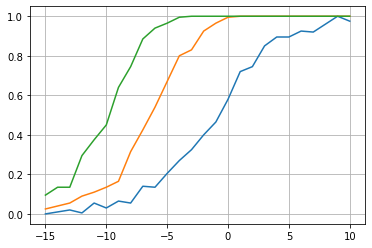

In [7]:
baselines = torch.load('baseline/mtl_fs_snr_baselines.pt')['baselines']

for seq_length in seq_lengths:
    plt.plot(snr_range, baselines[seq_length])
plt.grid()

## Data prep

In [8]:
def preprocess(data, labels, labels_snr, labels_cfo, to_onehot=True, abs_phase=False, gpu=True):
    
    # Convert labels to pytorch tensors
    if to_onehot:
        labels_oh = np.zeros(data.shape)
        for idx, label in enumerate(labels):
            labels_oh[idx,label] = 1
        labels = torch.FloatTensor(labels_oh)
    else:
        labels = torch.LongTensor(labels)
        
    labels_snr_extended = torch.FloatTensor(labels_snr.reshape(labels_snr.shape[0], 1).repeat(data.shape[1], axis=1))
    labels_cfo_extended = torch.FloatTensor(labels_cfo.reshape(labels_cfo.shape[0], 1).repeat(data.shape[1], axis=1))

    # Split into real and imaginary channels
    train_data = torch.FloatTensor(np.expand_dims(np.stack((data.real, data.imag),axis=1),axis=1))

    # Prep dataset for cuda if gpu true
    if gpu:
        train_data = train_data.cuda()
        labels = labels.cuda()
        labels_snr_extended = labels_snr_extended.cuda()
        labels_cfo_extended = labels_cfo_extended.cuda()
        
    return train_data, labels, labels_snr_extended, labels_cfo_extended

def gen_training_data(preamble_seq, num_examples = 1024, signal_length = 200, payload=128, max_snr = 10, normalize=False, add_phase_offset=False, add_channel=False, 
                      clean_outputs=False, sample_rate=1e6, add_carrier_offset=False, max_freq_offset=10e3):

    waveforms = np.random.randint(0,2,(num_examples, signal_length))
    waveforms = np.where(waveforms < 1, -1+0j, 1+0j)
    
    preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)
    
    # Pre-define array to contain complex-valued waveforms
#     waveforms = np.zeros((num_examples,signal_length),dtype=np.complex128)

    # Predefine labels array
    labels = np.zeros((num_examples,),dtype=int)
    
    labels_snr = np.zeros((num_examples,), dtype=float)
    labels_cfo = np.zeros((num_examples,), dtype=float)

    # Insert into random offset and save offset as label
    for idx, waveform in enumerate(waveforms):
        
        # Get random time offset
        tau = np.random.randint(0,signal_length-len(preamble_seq))
        
        # Insert packet at offset tau
        waveform[tau:tau+len(preamble_seq)] = preamble
        
        # Our label is the same time offset
        labels[idx] = tau
        
        # Add random phase offset
        if add_phase_offset:
            waveforms[idx] = phase_offset(waveform,offset=np.random.randint(-180,high=181))
        else:
            waveforms[idx] = waveform

        # Add flat fading channel
        if add_channel:
            gains = 1/np.sqrt(2)*(np.random.randn()+1j*np.random.randn())
            waveforms[idx] = gains*waveforms[idx]
            
        # Add frequency offset
        if add_carrier_offset:
            carrier_offset = np.random.randint(0, max_freq_offset)
            offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))
            waveforms[idx] = offset_sine*waveforms[idx]
    
        # Add noise
        snr = np.random.randint(-max_snr, max_snr) 
        waveforms[idx] = awgn(waveforms[idx], snr)

        labels_snr[idx] = float(snr)/max_snr
        labels_cfo[idx] = float(carrier_offset)/max_freq_offset
    
    # normalize
#     if normalize:
#         waveforms = (waveforms/np.max(np.abs(waveforms),axis=1)[:,None])

    return waveforms, labels, labels_snr, labels_cfo

class preamble_detector(nn.Module):
    def __init__(self):
        super(preamble_detector, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, (2,55), 1, padding=(0,27))
        self.conv2 = nn.Conv2d(32, 32, (1,55), 1, padding=(0,27))
        
        self.conv3 = nn.Conv2d(32,1,1,1)
        
    def forward(self, x):

        # First conv layer, correlation
        x = F.relu(self.conv1(x))
        
        # 2nd conv layer, non-linearities and cleanup
        x = F.relu(self.conv2(x))
        
        # Final linear / combining layer
        x = self.conv3(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

class preamble_detector_mtl(nn.Module):
    def __init__(self):
        super(preamble_detector_mtl, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, (2,55), 1, padding=(0,27))
        self.conv2 = nn.Conv2d(32, 32, (1,55), 1, padding=(0,27))
        
        self.conv3 = nn.Conv2d(32,1,1,1)
        
        self.snr_estimator = nn.Conv2d(32,1,1,1)

    def forward(self, x):

        # First conv layer, correlation
        x = F.relu(self.conv1(x))
        
        # 2nd conv layer, non-linearities and cleanup
        x = F.relu(self.conv2(x))
        
        # SNR estimation head
        snr = self.snr_estimator(x)
        snr = snr.squeeze()
        
        # Final linear / combining layer
        x = self.conv3(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x, snr

In [9]:
np.random.seed(2023)
for seq_length in seq_lengths:
    # training data
    train_data, labels, labels_snr, labels_cfo = gen_training_data(max_seq[:seq_length], num_examples=num_examples, max_snr=10, 
                                                                   signal_length=400, add_carrier_offset=True, max_freq_offset=1)
    train_data, labels, labels_snr, labels_cfo = preprocess(train_data, labels, labels_snr, labels_cfo, to_onehot=True)

    train_dataset = torch.utils.data.TensorDataset(train_data, labels, labels_snr, labels_cfo)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    # validation data
    val_data, val_labels, val_labels_snr, val_labels_cfo = gen_training_data(max_seq[:seq_length], num_examples=128, max_snr=10, 
                                                                             signal_length=400, add_carrier_offset=True, max_freq_offset=1)
    val_data, val_labels, val_labels_snr, val_labels_cfo = preprocess(val_data, val_labels, val_labels_snr, val_labels_cfo, to_onehot=True)

    val_dataset = torch.utils.data.TensorDataset(val_data, val_labels, val_labels_snr, val_labels_cfo)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    dataset = {'train_loader': train_loader,
               'val_loader': val_loader}

    torch.save(dataset, f"data/mtl_fs_snr_{num_examples}_{seq_length}.pt")

In [10]:
def train(detector, optimizer, train_loader, val_loader, loss_fn, num_epochs=5):

    losses, snr_losses, fs_losses = [], [], []
    val_losses = []

    best_loss = np.inf

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss, running_fs_loss, running_snr_loss = 0, 0, 0
        running_val_loss = 0

        for x_train, y_train, z_train, w_train in train_loader:

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = detector(x_train)

            loss = loss_fn(outputs, y_train)

            loss.backward()
            optimizer.step()

            running_loss = running_loss + loss.item()

        losses.append(running_loss/len(train_loader))

        with torch.no_grad():
            # evaluate validation loss
            for x_val, y_val, z_val, w_val in val_loader:
                val_outputs = detector(x_val)
                val_loss = loss_fn(val_outputs, y_val)
                running_val_loss = val_loss.item()
        
        val_losses.append(running_val_loss/len(val_loader))

        if val_losses[-1] < best_loss:
            print(f'val_losses[-1] = {val_losses[-1]}, best_loss = {best_loss}, model saved at {epoch}')
            saved_model = detector.state_dict()
            best_loss = val_losses[-1]

    detector.load_state_dict(saved_model)
    
    return detector, losses, val_losses

In [12]:
num_epochs = 30

for seq_length in seq_lengths:
    print(seq_length)
    models = []
    for i in range(num_models):
        print(f"iter {i}...")
        torch.manual_seed(i)
        
        dataset = torch.load(f"data/mtl_fs_snr_{num_examples}_{seq_length}.pt")
        train_loader = dataset['train_loader']
        val_loader = dataset['val_loader']

        detector = preamble_detector()
        detector.cuda()

        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(detector.parameters(), lr=0.001, weight_decay=0.001)

        detector, losses, val_losses = train(detector, optimizer, train_loader, val_loader, 
                                                                    loss_fn, num_epochs=num_epochs)

        model_config = {"weights": detector.state_dict(),
                        "losses": losses,
                        "val_losses": val_losses}

        models.append(model_config)

    torch.save(models, f'models/continuous/fs_{num_examples}_{seq_length}.pt')

16
iter 0...
val_losses[-1] = 0.0006412063376046717, best_loss = inf, model saved at 0
val_losses[-1] = 0.0005955626838840544, best_loss = 0.0006412063376046717, model saved at 1
val_losses[-1] = 0.0005198577418923378, best_loss = 0.0005955626838840544, model saved at 2
val_losses[-1] = 0.0004429582040756941, best_loss = 0.0005198577418923378, model saved at 3
val_losses[-1] = 0.00040260120294988155, best_loss = 0.0004429582040756941, model saved at 4
val_losses[-1] = 0.00039690471021458507, best_loss = 0.00040260120294988155, model saved at 5
val_losses[-1] = 0.00039008972817100585, best_loss = 0.00039690471021458507, model saved at 6
val_losses[-1] = 0.00037995463935658336, best_loss = 0.00039008972817100585, model saved at 7
val_losses[-1] = 0.0003764138964470476, best_loss = 0.00037995463935658336, model saved at 14
val_losses[-1] = 0.0003721752727869898, best_loss = 0.0003764138964470476, model saved at 20
val_losses[-1] = 0.0003704047412611544, best_loss = 0.0003721752727869898, 

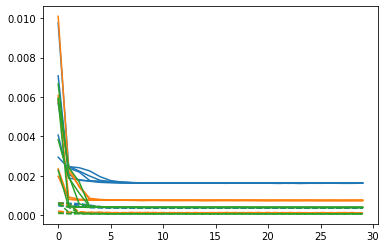

In [13]:
for i, seq_length in enumerate(seq_lengths):
    for model in torch.load(f'models/continuous/fs_{num_examples}_{seq_length}.pt'):
#         plt.plot(model['losses'], f'C{i}')
        plt.plot(model['losses'], f'C{i}')
        plt.plot(model['val_losses'], f'C{i}--')
# plt.ylim([0.002, 0.003])

In [14]:
def test(detector, preamble_seq, snr_range, num_runs=200, payload=128, signal_length=400):
    
    accs = []
    for snr in snr_range:
        corrects = 0
        for i in range(num_runs):
            
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))

            my_frame = create_frame(preamble_seq, payload=payload, signal_length=signal_length, offset=tau)
            my_frame = awgn(my_frame, snr)

            new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
            new_frame = torch.tensor(new_frame).float()
            nn_output = detector(new_frame)

            if nn_output.argmax() == tau:
                corrects += 1

        acc = corrects/num_runs
        accs.append(acc)
    return accs

In [15]:
for seq_length in seq_lengths:
    print(seq_length)
    results = []
    for model in torch.load(f'models/continuous/fs_{num_examples}_{seq_length}.pt'):
        detector = preamble_detector()
        detector.load_state_dict(model['weights'])

        accs = test(detector, max_seq[:seq_length], snr_range=snr_range, num_runs=500)
        
        result = {"accs": accs,
                   "snr_range": snr_range,
                   "model": detector}
        
        results.append(result)
    torch.save(results, f'results/continuous/fs_{num_examples}_{seq_length}.pt')

16
32
64


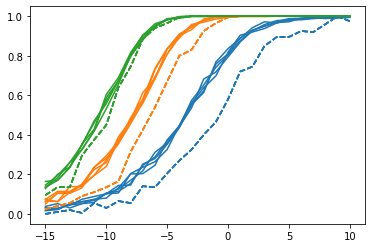

In [16]:
for i, seq_length in enumerate(seq_lengths):
    for result in torch.load(f'results/continuous/fs_{num_examples}_{seq_length}.pt'):
        plt.plot(result['snr_range'], result['accs'], f'C{i}')
        plt.plot(snr_range, baselines[seq_length], f'C{i}--')

## Add MTL

In [17]:
def train_mtl(detector, optimizer, train_loader, val_loader, loss_fn_fs, loss_fn_snr, num_epochs=5, loss_ratios=(1,0.5)):

    losses, snr_losses, fs_losses = [], [], []
    val_losses = []

    best_loss = np.inf

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss, running_fs_loss, running_snr_loss = 0, 0, 0

        for x_train, y_train, z_train, w_train in train_loader:

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, snr_outputs = detector(x_train)

            loss_fs = loss_fn_fs(outputs, y_train)
            loss_snr = loss_fn_snr(snr_outputs, z_train)

            loss = loss_ratios[0]*loss_fs + loss_ratios[1]*loss_snr

            loss.backward()
            optimizer.step()

            running_loss = running_loss + loss.item()
            running_fs_loss = running_fs_loss + loss_fs.item()
            running_snr_loss = running_snr_loss + loss_snr.item()

        losses.append(running_loss/len(train_loader))
        snr_losses.append(running_snr_loss/len(train_loader))
        fs_losses.append(running_fs_loss/len(train_loader))

        with torch.no_grad():
            # evaluate validation loss
            for x_val, y_val, z_val, w_val in val_loader:
                val_outputs, _ = detector(x_val)
                val_loss = loss_fn(val_outputs, y_val)
                running_val_loss = val_loss.item()
        
        val_losses.append(running_val_loss/len(val_loader))

        if val_losses[-1] < best_loss:
            print(f'val_losses[-1] = {val_losses[-1]}, best_loss = {best_loss}, model saved at {epoch}')
            saved_model = detector.state_dict()
            best_loss = val_losses[-1]

    detector.load_state_dict(saved_model)
    
    return detector, losses, val_losses, snr_losses, fs_losses

In [18]:
all_loss_ratios = []
for i in range(1,10):
    models = []

    fs_weight = 1
    snr_weight = round(1 - i*0.1, 1)
    
    loss_ratios = (fs_weight, snr_weight)
    
    all_loss_ratios.append(loss_ratios)
all_loss_ratios

[(1, 0.9),
 (1, 0.8),
 (1, 0.7),
 (1, 0.6),
 (1, 0.5),
 (1, 0.4),
 (1, 0.3),
 (1, 0.2),
 (1, 0.1)]

In [19]:
for loss_ratios in all_loss_ratios:
    print(loss_ratios)
    for seq_length in seq_lengths:
        print(seq_length)
        models = []
        for i in range(num_models):
            print(f'iter {i}...')
            torch.manual_seed(i)

            dataset = torch.load(f"data/mtl_fs_snr_{num_examples}_{seq_length}.pt")
            train_loader = dataset['train_loader']
            val_loader = dataset['val_loader']

            detector = preamble_detector_mtl()
            detector.cuda()

            loss_fn_fs = nn.MSELoss()
            loss_fn_snr = nn.MSELoss()
            optimizer = optim.Adam(detector.parameters(), lr=0.001, weight_decay=0.001)

            num_epochs = 30

            detector, losses, val_losses, snr_losses, fs_losses = train_mtl(detector, optimizer, train_loader, val_loader, 
                                                                            loss_fn_fs, loss_fn_snr, num_epochs=num_epochs,
                                                                            loss_ratios=loss_ratios)

            model_config = {"weights": detector.state_dict(),
                            "losses": losses,
                            "val_losses": val_losses,
                            "snr_losses": snr_losses,
                            "fs_losses": fs_losses}

            models.append(model_config)

        torch.save(models, f'models/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')

(1, 0.9)
16
iter 0...
val_losses[-1] = 0.0006399503909051418, best_loss = inf, model saved at 0
val_losses[-1] = 0.0006293138721957803, best_loss = 0.0006399503909051418, model saved at 1
val_losses[-1] = 0.0006278412765823305, best_loss = 0.0006293138721957803, model saved at 2
val_losses[-1] = 0.0006261595990508795, best_loss = 0.0006278412765823305, model saved at 3
val_losses[-1] = 0.0006242023082450032, best_loss = 0.0006261595990508795, model saved at 4
val_losses[-1] = 0.0006239560316316783, best_loss = 0.0006242023082450032, model saved at 9
val_losses[-1] = 0.0006230090511962771, best_loss = 0.0006239560316316783, model saved at 10
val_losses[-1] = 0.0006197315524332225, best_loss = 0.0006230090511962771, model saved at 11
val_losses[-1] = 0.0006155123701319098, best_loss = 0.0006197315524332225, model saved at 12
val_losses[-1] = 0.0006141015910543501, best_loss = 0.0006155123701319098, model saved at 13
val_losses[-1] = 0.0006060206796973944, best_loss = 0.000614101591054350

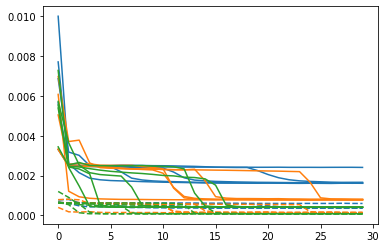

In [20]:
for i, seq_length in enumerate(seq_lengths):
    for model in torch.load(f'models/continuous/mtl_fs_snr_1_0.9_{num_examples}_{seq_length}.pt'):
#         plt.plot(model['losses'], f'C{i}')
        plt.plot(model['fs_losses'], f'C{i}')
        plt.plot(model['val_losses'], f'C{i}--')
# plt.ylim([0.002, 0.003])

## Test models

In [21]:
def test_mtl(detector, preamble_seq, snr_range, num_runs=200, payload=128, signal_length=400):
    
    accs = []
    for snr in snr_range:
        corrects = 0
        for i in range(num_runs):
            
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))

            my_frame = create_frame(preamble_seq, payload=payload, signal_length=signal_length, offset=tau)
            my_frame = awgn(my_frame, snr)

            new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
            new_frame = torch.tensor(new_frame).float()
            nn_output, cfo_hat = detector(new_frame)

            if nn_output.argmax() == tau:
                corrects += 1

        acc = corrects/num_runs
        accs.append(acc)
    return accs

In [22]:
for loss_ratios in all_loss_ratios:
    print(f"Evaling {loss_ratios}")
    for seq_length in seq_lengths:
        print(seq_length)
        results = []
        for model in torch.load(f'models/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt'):
            detector = preamble_detector_mtl()
            detector.load_state_dict(model['weights'])

            accs = test_mtl(detector, max_seq[:seq_length], snr_range=snr_range, num_runs=500)

            result = {"accs": accs,
                       "snr_range": snr_range,
                       "model": model}

            results.append(result)
        torch.save(results, f'results/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')

Evaling (1, 0.9)
16
32
64
Evaling (1, 0.8)
16
32
64
Evaling (1, 0.7)
16
32
64
Evaling (1, 0.6)
16
32
64
Evaling (1, 0.5)
16
32
64
Evaling (1, 0.4)
16
32
64
Evaling (1, 0.3)
16
32
64
Evaling (1, 0.2)
16
32
64
Evaling (1, 0.1)
16
32
64


In [23]:
all_loss_ratios = []
for i in range(1,10):
    models = []

    fs_weight = round(i*0.1,1)
    snr_weight = round(1 - i*0.1, 1)
    
    loss_ratios = (fs_weight, snr_weight)
    
    all_loss_ratios.append(loss_ratios)
all_loss_ratios

[(0.1, 0.9),
 (0.2, 0.8),
 (0.3, 0.7),
 (0.4, 0.6),
 (0.5, 0.5),
 (0.6, 0.4),
 (0.7, 0.3),
 (0.8, 0.2),
 (0.9, 0.1)]

In [24]:
for loss_ratios in all_loss_ratios:
    print(loss_ratios)
    for seq_length in seq_lengths:
        print(seq_length)
        models = []
        for i in range(num_models):
            print(f'iter {i}...')
            torch.manual_seed(i)

            dataset = torch.load(f"data/mtl_fs_snr_{num_examples}_{seq_length}.pt")
            train_loader = dataset['train_loader']
            val_loader = dataset['val_loader']

            detector = preamble_detector_mtl()
            detector.cuda()

            loss_fn_fs = nn.MSELoss()
            loss_fn_snr = nn.MSELoss()
            optimizer = optim.Adam(detector.parameters(), lr=0.001, weight_decay=0.001)

            num_epochs = 30

            detector, losses, val_losses, snr_losses, fs_losses = train_mtl(detector, optimizer, train_loader, val_loader, 
                                                                            loss_fn_fs, loss_fn_snr, num_epochs=num_epochs,
                                                                            loss_ratios=loss_ratios)

            model_config = {"weights": detector.state_dict(),
                            "losses": losses,
                            "val_losses": val_losses,
                            "snr_losses": snr_losses,
                            "fs_losses": fs_losses}

            models.append(model_config)

        torch.save(models, f'models/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')

(0.1, 0.9)
16
iter 0...
val_losses[-1] = 0.0006734164198860526, best_loss = inf, model saved at 0
val_losses[-1] = 0.0006475901464000344, best_loss = 0.0006734164198860526, model saved at 1
val_losses[-1] = 0.0006396989338099957, best_loss = 0.0006475901464000344, model saved at 2
val_losses[-1] = 0.0006313839694485068, best_loss = 0.0006396989338099957, model saved at 3
val_losses[-1] = 0.0006281970418058336, best_loss = 0.0006313839694485068, model saved at 4
val_losses[-1] = 0.000625939923338592, best_loss = 0.0006281970418058336, model saved at 5
val_losses[-1] = 0.0006249369471333921, best_loss = 0.000625939923338592, model saved at 6
val_losses[-1] = 0.0006239913054741919, best_loss = 0.0006249369471333921, model saved at 7
val_losses[-1] = 0.0006233396125026047, best_loss = 0.0006239913054741919, model saved at 8
val_losses[-1] = 0.0006229704595170915, best_loss = 0.0006233396125026047, model saved at 9
val_losses[-1] = 0.0006228489801287651, best_loss = 0.0006229704595170915, m

In [ ]:
for loss_ratios in all_loss_ratios:
    print(f"Evaling {loss_ratios}")
    for seq_length in seq_lengths:
        print(seq_length)
        results = []
        for model in torch.load(f'models/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt'):
            detector = preamble_detector_mtl()
            detector.load_state_dict(model['weights'])

            accs = test_mtl(detector, max_seq[:seq_length], snr_range=snr_range, num_runs=500)

            result = {"accs": accs,
                       "snr_range": snr_range,
                       "model": model}

            results.append(result)
        torch.save(results, f'results/continuous/mtl_fs_snr_{loss_ratios[0]}_{loss_ratios[1]}_{num_examples}_{seq_length}.pt')